In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from os.path import join, basename, dirname
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted
from tqdm import tqdm
import torch

from torchvision.io import read_image
from torchvision.utils import make_grid
from torchvision import transforms

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from experiment_utils import set_env, REPO_PATH, seed_everything
set_env()

In [5]:
from image_utils import denormalize, show_single_image, show_multiple_images
from cgn_framework.imagenet.dataloader import get_imagenet_dls
from cgn_framework.imagenet.models.classifier_ensemble import InvariantEnsemble
from cgn_framework.imagenet.models import CGN
from experiments.imagenet_utils import (
    EnsembleGradCAM,
    get_imagenet_mini_foldername_to_classname,
)

In [6]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Load CGN model

In [7]:
seed_everything(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# load data
print("Loading data ...")
train_loader, val_loader, train_sampler = get_imagenet_dls(
    "imagenet/data/in-mini", False, 64, 10,
)
ds_val = val_loader.dataset

Loading data ...


In [9]:
# load CGN model
print("Loading CGN model ...")
cgn = CGN(batch_sz=1, pretrained=False)
weights = torch.load(join(REPO_PATH, 'cgn_framework/imagenet/weights/cgn.pth'), map_location='cpu')
cgn.load_state_dict(weights)
cgn.eval().to(device);

Loading CGN model ...


In [10]:
def generate(ys):
    
    clf_transforms=ds_val.T_ims

    with torch.no_grad():
        x_gt, mask, premask, foreground, background, bg_mask = cgn(ys=ys)
        x_gen = mask * foreground + (1 - mask) * background

    image = x_gen[0]
    pil_image = transforms.ToPILImage()((image + 1) * 0.5)
    transformed_image = clf_transforms(pil_image)

    foreground = foreground[0]
    foreground = transforms.ToPILImage()((foreground + 1) * 0.5)
    foreground = clf_transforms(foreground)
    
    mask = mask[0]

    background = background[0]
    background = transforms.ToPILImage()((background + 1) * 0.5)
    background = clf_transforms(background)

    result = {
        "x_gen": transformed_image,
        "mask": mask,
        "premask": premask,
        "fg": foreground,
        "bg": background,
    }
    return result

In [11]:
result = generate([0, 1, 2])

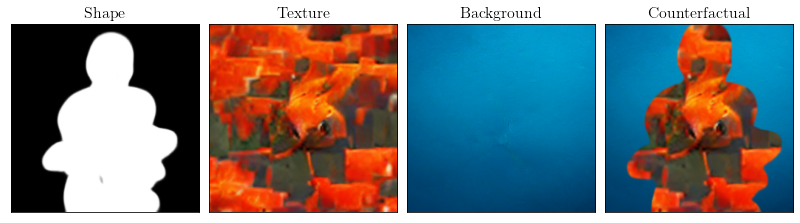

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(11, 3), constrained_layout=True)

keys_to_show = ["mask", "fg", "bg", "x_gen"]
titles = ["Shape", "Texture", "Background", "Counterfactual"]

show_single_image(result["mask"], normalized=False, ax=axes[0], title=titles[0], show=False, cmap="gray")
show_single_image(result["fg"], normalized=True, ax=axes[1], title=titles[1], show=False)
show_single_image(result["bg"], normalized=True, ax=axes[2], title=titles[2], show=False)
show_single_image(result["x_gen"], normalized=True, ax=axes[3], title=titles[3], show=False)

plt.show()